# Invasive species competition

To start you will need to download and unzip the competition data from Kaggle and ensure your directory structure looks like this
```
utils/
    vgg16.py
    utils.py
lesson1/
    redux.ipynb
    data/
        redux/
            train/
                cat.437.jpg
                dog.9924.jpg
                cat.1029.jpg
                dog.4374.jpg
            test/
                231.jpg
                325.jpg
                1235.jpg
                9923.jpg
```

You can download the data files from the competition page [here](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) or you can download them from the command line using the [Kaggle CLI](https://github.com/floydwch/kaggle-cli).

You should launch your notebook inside the lesson1 directory
```
cd lesson1
jupyter notebook
```

In [1]:
#Verify we are in the lesson1 directory
%pwd

u'/home/sergio/git/courses/deeplearning1/nbs'

In [2]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = "/home/sergio/datasets/invasive/"

In [3]:
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#import modules
from utils import *
from vgg16 import Vgg16

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K20m (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


## Action Plan
1. Create Validation and Sample sets
2. Rearrange image files into their respective directories 
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Finetune extra dense layers
7. Submit predictions to Kaggle

## Rename files by class
Invasive or non-invasive



In [12]:
import csv
%cd $DATA_HOME_DIR/train

with open(DATA_HOME_DIR + 'train_labels.csv') as csvfile:
    csvdata = csv.reader(csvfile, delimiter=',')
    clsdic = dict(csvdata)
    clslit = ['local', 'invasive']
    for f in glob('*.jpg'):
        id = f[:f.find('.')]
        if not (f.startswith('local') or f.startswith('invasive')):
            os.rename(f, clslit[int(clsdic[id])] + '-' + f)

/home/sergio/datasets/invasive/train


## Create validation set and sample

In [11]:
#Create directories
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/sergio/datasets/invasive
mkdir: cannot create directory ‘valid’: File exists
mkdir: cannot create directory ‘results’: File exists


In [5]:
%cd $DATA_HOME_DIR/train

/home/sergio/datasets/invasive/train


In [13]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(295): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

In [14]:
from shutil import copyfile

In [15]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])

In [16]:
%cd $DATA_HOME_DIR/valid

/home/sergio/datasets/invasive/valid


In [17]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

## Rearrange image files into their respective directories

In [25]:
#Divide cat/dog images into separate directories

%cd $DATA_HOME_DIR/sample/train
%mkdir invasives
%mkdir locals
%mv invasive*.jpg invasives/
%mv local*.jpg locals/

%cd $DATA_HOME_DIR/sample/valid
%mkdir invasives
%mkdir locals
%mv invasive*.jpg invasives/
%mv local*.jpg locals/

%cd $DATA_HOME_DIR/valid
%mkdir invasives
%mkdir locals
%mv invasive*.jpg invasives/
%mv local*.jpg locals/

%cd $DATA_HOME_DIR/train
%mkdir invasives
%mkdir locals
%mv invasive*.jpg invasives/
%mv local*.jpg locals/

/home/sergio/datasets/invasive/sample/train
mkdir: cannot create directory ‘invasives’: File exists
mkdir: cannot create directory ‘locals’: File exists
mv: cannot stat ‘invasive*.jpg’: No such file or directory
mv: cannot stat ‘local*.jpg’: No such file or directory
/home/sergio/datasets/invasive/sample/valid
mkdir: cannot create directory ‘invasives’: File exists
mkdir: cannot create directory ‘locals’: File exists
mv: cannot stat ‘invasive*.jpg’: No such file or directory
mv: cannot stat ‘local*.jpg’: No such file or directory
/home/sergio/datasets/invasive/valid
mkdir: cannot create directory ‘locals’: File exists
mv: cannot stat ‘local*.jpg’: No such file or directory
/home/sergio/datasets/invasive/train
mkdir: cannot create directory ‘locals’: File exists
mv: cannot stat ‘local*.jpg’: No such file or directory


In [26]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/home/sergio/datasets/invasive/test


## Finetuning and Training

In [12]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' '/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + 'results/'
train_path=path + '/train/'
valid_path=path + '/valid/'
print results_path

/home/sergio/datasets/invasive
/home/sergio/datasets/invasive/results/


In [5]:
#import Vgg16 helper class
vgg = Vgg16()

In [9]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=32
no_of_epochs=3

In [10]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [22]:
import gc
for i in range(3): gc.collect()

In [11]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % no_of_epochs

Running epoch: 0
Epoch 1/1


MemoryError: Error allocating 212926464 bytes of device memory (out of memory).
Apply node that caused the error: GpuAlloc{memset_0=True}(CudaNdarrayConstant{0.0}, Shape_i{0}.0, TensorConstant{128}, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0)
Toposort index: 199
Inputs types: [CudaNdarrayType(float32, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar)]
Inputs shapes: [(), (), (), (), ()]
Inputs strides: [(), (), (), (), ()]
Inputs values: [CudaNdarray(0.0), array(32), array(128), array(114), array(114)]
Outputs clients: [[GpuIncSubtensor{InplaceSet;::, ::, int64:int64:, int64:int64:}(GpuAlloc{memset_0=True}.0, GpuElemwise{Composite{(i0 * ((i1 + i2) + Abs((i1 + i2))))}}[(0, 1)].0, Constant{1}, ScalarFromTensor.0, Constant{1}, ScalarFromTensor.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## Generate Predictions

Let's use our new model to make predictions on the test dataset

In [36]:
if os.path.isfile(results_path + 'ft2.h5'):
    print "Loading weights..."
    vgg.model.load_weights(results_path + 'ft2.h5')
    
print vgg.model

Loading weights...


In [37]:
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

Found 1531 images belonging to 1 classes.


In [38]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print preds[:5]

filenames = batches.filenames
print filenames[:5]

[[  1.8859e-10   1.0000e+00]
 [  1.0000e+00   1.3828e-24]
 [  1.0000e+00   5.4839e-23]
 [  1.0000e+00   2.2213e-06]
 [  6.7752e-06   9.9999e-01]]
['unknown/1121.jpg', 'unknown/869.jpg', 'unknown/866.jpg', 'unknown/380.jpg', 'unknown/638.jpg']


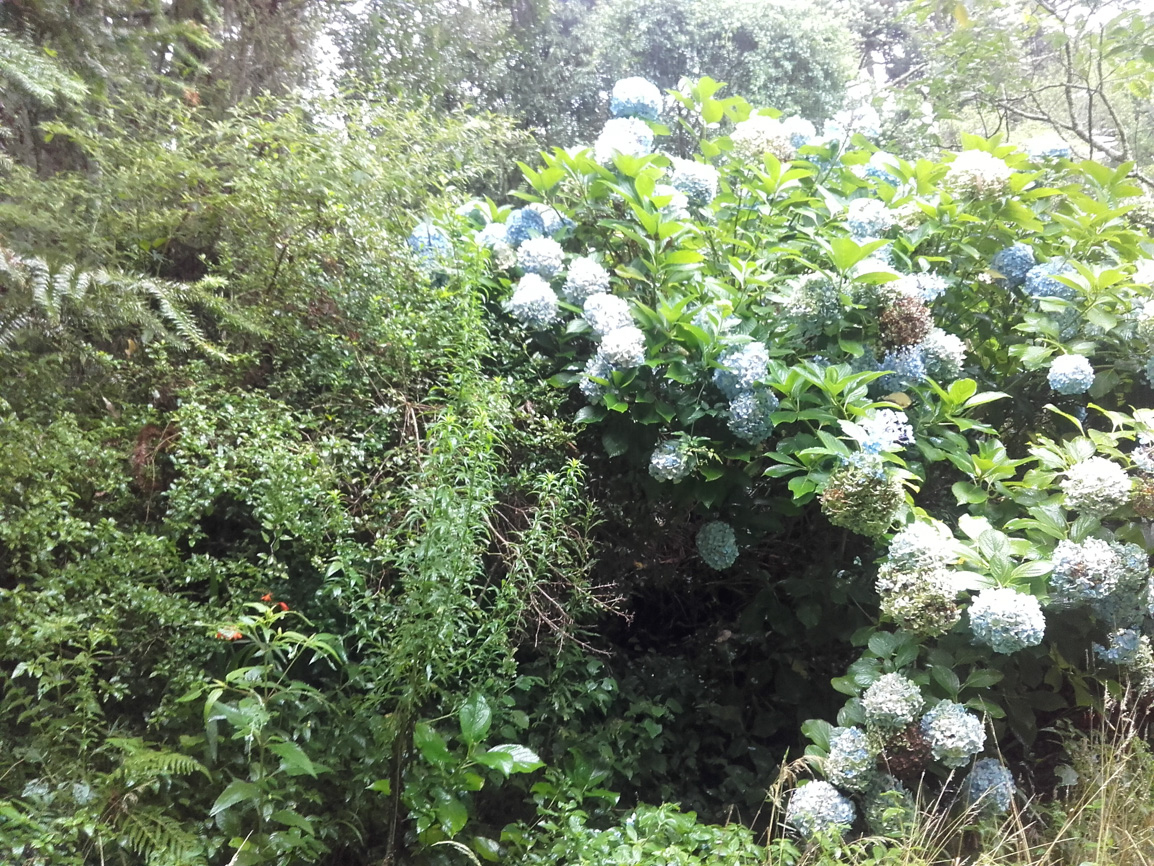

In [39]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + filenames[2])

In [40]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Validate Predictions

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [41]:
latest_weights_filename = 'ft2.h5'
vgg.model.load_weights(results_path+latest_weights_filename)

In [42]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 295 images belonging to 2 classes.


In [43]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [44]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 262 correct labels


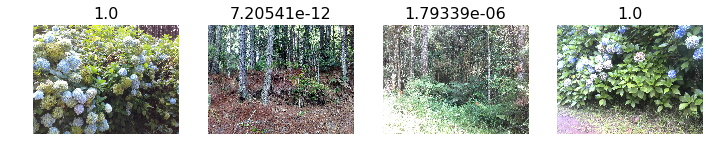

In [45]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 33 incorrect labels


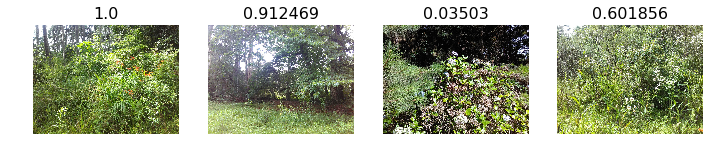

In [46]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 170 confident correct invasive labels


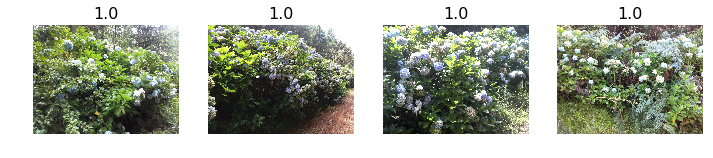

In [51]:
#3a. The images we most confident were invasive, and are actually invasive
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct invasive labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 92 confident correct locals labels


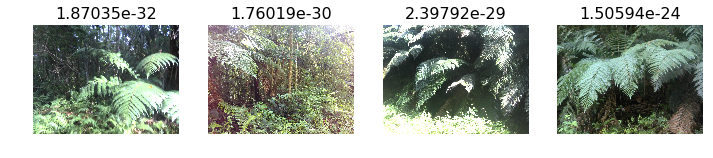

In [56]:
#3b. The images we most confident were locals, and are actually locals
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct locals labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 17 incorrect locals


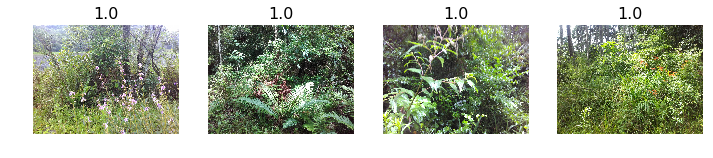

In [59]:
#4a. The images we were most confident were locals, but are actually invasives
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect locals" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 16 incorrect invasives


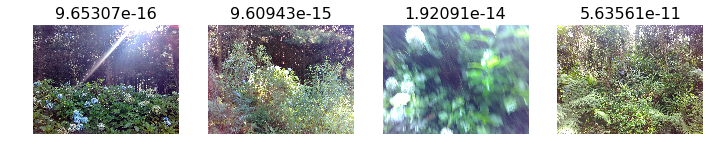

In [60]:
#4b. The images we were most confident were invasive, but are actually locals
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect invasives" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

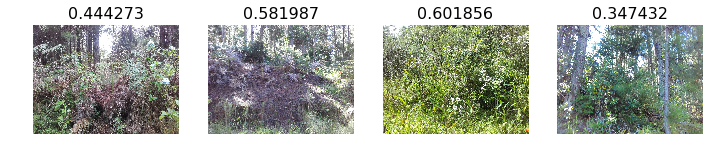

In [61]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [62]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[170  16]
 [ 17  92]]


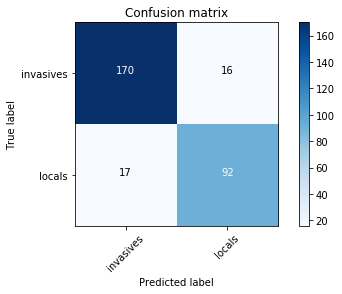

In [64]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Finetune some extra dense layers

The code below will work on any model that contains dense layers; it's not just for this VGG model.

NB: Don't skip the step of fine-tuning just the final layer first, since otherwise you'll have one layer with random weights, which will cause the other layers to quickly move a long way from their optimized imagenet weights.

In [20]:
# reload the model
model = vgg_ft(2)
latest_weights_filename = 'ft2.h5'
model.load_weights(results_path+latest_weights_filename)

batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)

Found 2000 images belonging to 2 classes.
Found 295 images belonging to 2 classes.


In [21]:
layers = model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
print first_dense_idx
# ...and set this and all subsequent layers to trainable (ensure that the rest are non-trainable)
for idx,layer in enumerate(layers): 
    if(idx < first_dense_idx):
        layer.trainable=False
    else:
        layer.trainable=True
model.summary()

33
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 3, 224, 224)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
zeropadding2d_27 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_27[0][0]           
____________________________________________________________________________________________________
zeropadding2d_28 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_27[0][0]           
________________________________________________________________________________________

Since we haven't changed our architecture, there's no need to re-compile the model - instead, we just set the learning rate. Since we're training more layers, and since we've already optimized the last layer, we should use a lower learning rate than previously.




In [18]:
opt = RMSprop(lr=0.1) # we compile again because optimizer was changed
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

fit_model(model, batches, val_batches, 3)

This is an extraordinarily powerful 5 lines of code. We have fine-tuned all of our dense layers to be optimized for our specific data set. This kind of technique has only become accessible in the last year or two - and we can already do it in just 5 lines of python!

In [ ]:
model.save_weights(results_path+'finetune-lesson2-1.h5')


There's generally little room for improvement in training the convolutional layers, if you're using the model on natural images (as we are). However, there's no harm trying a few of the later conv layers, since it may give a slight improvement, and can't hurt (and we can always load the previous weights if the accuracy decreases).


In [19]:
for layer in layers[12:]: layer.trainable=True
keras.backend.set_value(opt.lr, 0.001)

fit_model(model, batches, val_batches, 4)

model.save_weights(results_path+'finetune-lesson2-2.h5')

You can always load the weights later and use the model to do whatever you need:


In [ ]:
#model.load_weights(results_path+'finetune2.h5')
#model.evaluate_generator(get_batches('valid', gen, False, batch_size*2), val_batches.N)

## Remove dropout



Our high level approach here will be to start with our fine-tuned cats vs dogs model (with dropout), then fine-tune all the dense layers, after removing dropout from them. The steps we will take are:

* Re-create and load our modified VGG model with binary dependent (i.e. dogs v cats)
* Split the model between the convolutional (conv) layers and the dense layers
* Pre-calculate the output of the conv layers, so that we don't have to redundently re-calculate them on every epoch
* Create a new model with just the dense layers, and dropout p set to zero
* Train this new model using the output of the conv layers as training data.



In [ ]:
# reload model

model = vgg_ft(2)
model.load_weights(model_path+'finetune-lesson2-2.h5')

In [25]:
layers = model.layers
last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]
print last_conv_idx
conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)
# Dense layers - also known as fully connected or 'FC' layers
fc_layers = layers[last_conv_idx+1:]




batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)


30
Found 2000 images belonging to 2 classes.
Found 295 images belonging to 2 classes.


KeyboardInterrupt: 

In [ ]:
trn_features = conv_model.predict_generator(batches, batches.nb_sample)
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)



save_array(results_path + 'train_convlayer_features.bc', trn_features)
save_array(results_path + 'valid_convlayer_features.bc', val_features)


trn_features.shape



For our new fully connected model, we'll create it using the exact same architecture as the last layers of VGG 16, so that we can conveniently copy pre-trained weights over from that model. However, we'll set the dropout layer's p values to zero, so as to effectively remove dropout.


In [ ]:
# Copy the weights from the pre-trained model.
# NB: Since we're removing dropout, we want to half the weights
def proc_wgts(layer): return [o/2 for o in layer.get_weights()]

# Such a finely tuned model needs to be updated very slowly!
opt = RMSprop(lr=0.00001, rho=0.7)

def get_fc_model():
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(2, activation='softmax')
        ])

    for l1,l2 in zip(model.layers, fc_layers): l1.set_weights(proc_wgts(l2))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

fc_model = get_fc_model()

fc_model.fit(trn_features, trn_labels, nb_epoch=8, 
             batch_size=batch_size, validation_data=(val_features, val_labels))





## Submit Predictions to Kaggle!

Here's the format Kaggle requires for new submissions:
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

Kaggle wants the imageId followed by the probability of the image being a dog. Kaggle uses a metric called [Log Loss](http://wiki.fast.ai/index.php/Log_Loss) to evaluate your submission.

In [74]:
#Load our test predictions from file
#preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

# or predict again

preds = model.predict_generator(test_batches, test_batches.nb_sample)

In [75]:
#Grab the dog prediction column
isdog = preds[:,1]
print "Raw Predictions: " + str(isdog[:5])
print "Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)])
print "Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)])

Raw Predictions: [  1.0000e+00   1.3828e-24   5.4839e-23   2.2213e-06   9.9999e-01]
Mid Predictions: [ 0.4588  0.4968  0.5942  0.5749  0.5485  0.5643  0.5298  0.4427  0.4554  0.4696  0.5959  0.4031
  0.4191  0.5223  0.4011]
Edge Predictions: [ 1.  1.  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

[Log Loss](http://wiki.fast.ai/index.php/Log_Loss) doesn't support probability values of 0 or 1--they are undefined (and we have many). Fortunately, Kaggle helps us by offsetting our 0s and 1s by a very small value. So if we upload our submission now we will have lots of .99999999 and .000000001 values. This seems good, right?

Not so. There is an additional twist due to how log loss is calculated--log loss rewards predictions that are confident and correct (p=.9999,label=1), but it punishes predictions that are confident and wrong far more (p=.0001,label=1). See visualization below.

In [77]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([1],[[i*.0001,1-(i*.0001)]],eps=1e-15) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

ValueError: y_true contains only one label (1). Please provide the true labels explicitly through the labels argument.

In [78]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)
print isdog.shape

(1531,)


In [79]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
print filenames[:10]
ids = np.array([int(f[8:f.find('.')]) for f in filenames])
print ids[:10]
print ids.shape

['unknown/1121.jpg', 'unknown/869.jpg', 'unknown/866.jpg', 'unknown/380.jpg', 'unknown/638.jpg', 'unknown/242.jpg', 'unknown/53.jpg', 'unknown/1130.jpg', 'unknown/190.jpg', 'unknown/958.jpg']
[1121  869  866  380  638  242   53 1130  190  958]
(1531,)


Here we join the two columns into an array of [imageId, isDog]

In [80]:
subm = np.stack([ids,isdog], axis=1)
print subm.shape
subm[:5,]

(1531, 2)


array([[  1.1210e+03,   9.5000e-01],
       [  8.6900e+02,   5.0000e-02],
       [  8.6600e+02,   5.0000e-02],
       [  3.8000e+02,   5.0000e-02],
       [  6.3800e+02,   9.5000e-01]])

In [89]:
%cd $LESSON_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

/home/sergio/git/courses/deeplearning1/nbs


In [91]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink(submission_file_name)

/home/sergio/git/courses/deeplearning1/nbs


/home/sergio/git/courses/deeplearning1/nbs/submission1.csv

You can download this file and submit on the Kaggle website or use the Kaggle command line tool's "submit" method.